# SOTA Activation Zone Generator
By: Ara Kourchians - N6ARA

In [1]:
summit_ref = "W6SC229"    # SOTA Summit Reference (no slashes or dash)
summit_lat = 34.0738      # Latitude in degrees (Source: SOTA Database)
summit_long = -118.8328   # Longitude in degrees (Source: SOTA Database)
summit_alt = 764          # Altitude in meters (Source: SOTA Database)

deg_delta = 0.010             # Increase this parameter if the summit AZ is large
sota_summit_alt_thres = 25    # Per SOTA Rules April 2015 - Activation Zone is within 25 vertical meters of peak

In [2]:
# Install dependencies if you don't already have them by uncommenting the following:
#import sys
#!{sys.executable} -m pip install osgeo
#!{sys.executable} -m pip install gdal
#!{sys.executable} -m pip install elevation

In [3]:
from osgeo import gdal
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import elevation

In [4]:
# Generate the extent
summit_lat_min = float('{:.8f}'.format(summit_lat-deg_delta))
summit_lat_max = float('{:.8f}'.format(summit_lat+deg_delta))
summit_long_min = float('{:.8f}'.format(summit_long-deg_delta))
summit_long_max = float('{:.8f}'.format(summit_long+deg_delta))

summit_extent = [summit_long_min,summit_long_max,summit_lat_min,summit_lat_max]
print(summit_extent)

# Set SOTA Altitude AZ (Activation Zone) Cutoff
summit_alt_az_min = summit_alt - sota_summit_alt_thres
print("AZ Altitude Cutoff: ", summit_alt_az_min)

# Download DEM
!mkdir data
!eio clip -o data/{summit_ref}-30m-DEM.tif --bounds {summit_long_min} {summit_lat_min} {summit_long_max} {summit_lat_max}

[-118.8428, -118.8228, 34.0638, 34.0838]
AZ Altitude Cutoff:  739
make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.df02e6f4086a4f518d469b682a9d7d61.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -118.8428 34.0838 -118.8228 34.0638 SRTM1.df02e6f4086a4f518d469b682a9d7d61.vrt /Users/arko/GitHub/azgen/data/W6SC229-30m-DEM.tif
rm -f SRTM1.df02e6f4086a4f518d469b682a9d7d61.vrt


In [5]:
# Load DEM
filename = "data/" + summit_ref + "-30m-DEM.tif"
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
dem = gdal_data.ReadAsArray().astype(np.float)

# replace missing values if necessary
if np.any(dem == nodataval):
    dem[dem == nodataval] = np.nan

/var/folders/56/nrjnt_7502345jgyjl4c6lvh0000gn/T/ipykernel_1961/3377088072.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dem = gdal_data.ReadAsArray().astype(np.float)


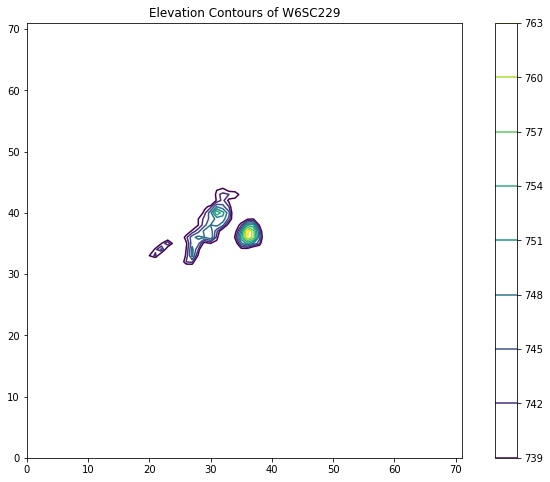

In [6]:
# Plot DEM data with Matplotlib contour
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contour(dem, cmap = "viridis", 
            levels = list(range(summit_alt_az_min, summit_alt, 3)))
plt.title("Elevation Contours of " + summit_ref)
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

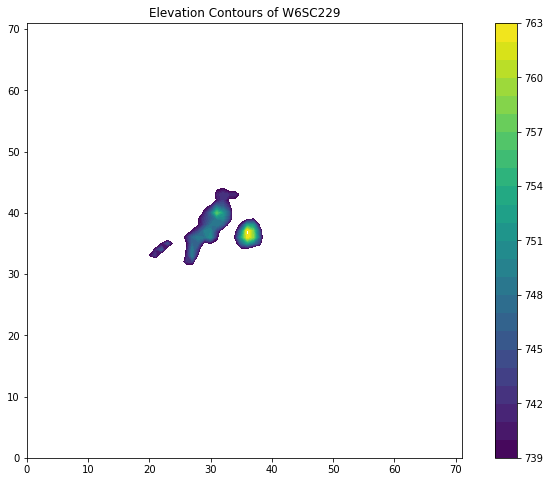

In [7]:
# Plot DEM data with Matplotlib gradients
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(dem, cmap = "viridis", 
            levels = list(range(summit_alt_az_min, summit_alt, 1)))
plt.title("Elevation Contours of " + summit_ref)
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

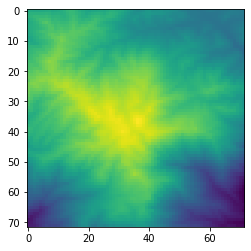

Data Array Size: (72, 72)
[[555. 557. 554. ... 456. 453. 452.]
 [566. 573. 573. ... 457. 450. 448.]
 [572. 580. 588. ... 448. 445. 442.]
 ...
 [265. 270. 288. ... 255. 254. 246.]
 [263. 273. 290. ... 241. 239. 234.]
 [272. 280. 285. ... 244. 244. 244.]]


In [8]:
# Plot raw DEM data
plt.imshow(dem)
plt.show()
print("Data Array Size:", dem.shape)
print(dem)

36 36


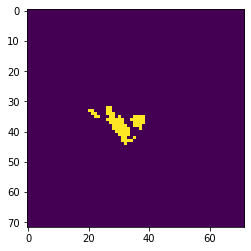

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
# Plot Activation Zone Altitude Mask (all data points at or above alt cutoff)
num_x, num_y = dem.shape

center_x = int(num_x/2)
center_y = int(num_y/2)
print(center_x, center_y)

az_mask = np.zeros((num_x, num_y))

for x in range(num_x):
    for y in range(num_y):
        if dem[x,y] >= summit_alt_az_min:
            az_mask[x,y] = 1

plt.imshow(az_mask)
plt.show()
print(az_mask)

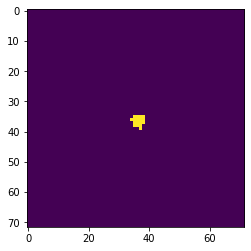

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


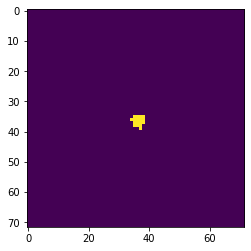

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
# Filter data points that are both within the 
# activation zone altitude and are connected to the summit
az_mask_s = np.zeros((num_x, num_y))
az_mask_s[center_x,center_y] = 2 

az = np.zeros((num_x, num_y))

# Start at the summit (center) and expand outward until outside the AZ
#    0 = Unassigned or outside of AZ
#    1 = Within AZ
#    2 = Marked for searching outward
while 2 in az_mask_s:
    for x in range(num_x):
        for y in range(num_y):
            if az_mask_s[x,y] == 2 and az_mask[x,y] == 1:
                
                if az_mask_s[x+1,y+1] == 0 and az_mask[x+1,y+1] == 1:
                    az_mask_s[x+1,y+1] = 2
                
                if az_mask_s[x+1,y-1] == 0 and az_mask[x+1,y-1] == 1:
                    az_mask_s[x+1,y-1] = 2
                
                if az_mask_s[x-1,y+1] == 0 and az_mask[x-1,y+1] == 1:
                    az_mask_s[x-1,y+1] = 2
                    
                if az_mask_s[x-1,y-1] == 0 and az_mask[x-1,y-1] == 1:
                    az_mask_s[x-1,y-1] = 2

                if az_mask_s[x+1,y] == 0 and az_mask[x+1,y] == 1:
                    az_mask_s[x+1,y] = 2
                
                if az_mask_s[x-1,y] == 0 and az_mask[x-1,y-1] == 1:
                    az_mask_s[x-1,y] = 2
                
                if az_mask_s[x,y+1] == 0 and az_mask[x,y+1] == 1:
                    az_mask_s[x,y+1] = 2
                
                if az_mask_s[x,y-1] == 0 and az_mask[x,y-1] == 1:
                    az_mask_s[x,y-1] = 2

            if az_mask_s[x,y] == 2:
                az_mask_s[x,y] = 1

# The following is meant for future use. Copying az_mask_s directly to az works just as well.
for x in range(num_x):
    for y in range(num_y):
        if az_mask_s[x,y] == 1 and az_mask[x,y] == 1:
            az[x,y] = 1


# Plot AZ Mask
plt.imshow(az_mask_s)
plt.show()
print(az_mask_s)

# Plot AZ
plt.imshow(az)
plt.show()
print(az)

In [11]:
# Generate Latitude and Longitude array (shares indices with az)

# Calculate lat/long step per index
az_lat_step = (summit_lat_max-summit_lat_min)/num_y
az_long_step = (summit_long_max-summit_long_min)/num_x

print(az_lat_step)
print(az_long_step)

lat = np.zeros((num_x, num_y))
long = np.zeros((num_x, num_y))

# Calculate Lat/Long array
for x in range(num_x):
    for y in range(num_y):
        lat[x,y] = summit_lat_max - (az_lat_step*x)
        long[x,y] = summit_long_min + (az_long_step*y)

print(lat)
print(long)

0.00027777777777772254
0.00027777777777772254
[[34.0838     34.0838     34.0838     ... 34.0838     34.0838
  34.0838    ]
 [34.08352222 34.08352222 34.08352222 ... 34.08352222 34.08352222
  34.08352222]
 [34.08324444 34.08324444 34.08324444 ... 34.08324444 34.08324444
  34.08324444]
 ...
 [34.06463333 34.06463333 34.06463333 ... 34.06463333 34.06463333
  34.06463333]
 [34.06435556 34.06435556 34.06435556 ... 34.06435556 34.06435556
  34.06435556]
 [34.06407778 34.06407778 34.06407778 ... 34.06407778 34.06407778
  34.06407778]]
[[-118.8428     -118.84252222 -118.84224444 ... -118.82363333
  -118.82335556 -118.82307778]
 [-118.8428     -118.84252222 -118.84224444 ... -118.82363333
  -118.82335556 -118.82307778]
 [-118.8428     -118.84252222 -118.84224444 ... -118.82363333
  -118.82335556 -118.82307778]
 ...
 [-118.8428     -118.84252222 -118.84224444 ... -118.82363333
  -118.82335556 -118.82307778]
 [-118.8428     -118.84252222 -118.84224444 ... -118.82363333
  -118.82335556 -118.823077

In [12]:
# Print all AZ data points
for x in range(num_x):
    for y in range(num_y):
        if az[x,y] == 1:
            print("Lat: ", lat[x,y], "Long: ", long[x,y], "Alt: ", dem[x,y])

Lat:  34.074077777777774 Long:  -118.83307777777777 Alt:  747.0
Lat:  34.074077777777774 Long:  -118.83279999999999 Alt:  752.0
Lat:  34.074077777777774 Long:  -118.83252222222222 Alt:  748.0
Lat:  34.074077777777774 Long:  -118.83224444444444 Alt:  743.0
Lat:  34.0738 Long:  -118.83335555555556 Alt:  740.0
Lat:  34.0738 Long:  -118.83307777777777 Alt:  753.0
Lat:  34.0738 Long:  -118.83279999999999 Alt:  763.0
Lat:  34.0738 Long:  -118.83252222222222 Alt:  759.0
Lat:  34.0738 Long:  -118.83224444444444 Alt:  746.0
Lat:  34.07352222222222 Long:  -118.83307777777777 Alt:  749.0
Lat:  34.07352222222222 Long:  -118.83279999999999 Alt:  765.0
Lat:  34.07352222222222 Long:  -118.83252222222222 Alt:  758.0
Lat:  34.07352222222222 Long:  -118.83224444444444 Alt:  745.0
Lat:  34.07324444444444 Long:  -118.83307777777777 Alt:  741.0
Lat:  34.07324444444444 Long:  -118.83279999999999 Alt:  753.0
Lat:  34.07324444444444 Long:  -118.83252222222222 Alt:  752.0
Lat:  34.072966666666666 Long:  -118.8

In [13]:
# Generate GPX and Activation Zone shapefile
from osgeo import ogr
from osgeo import osr
import fileinput
from datetime import datetime
import os

srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

driver = ogr.GetDriverByName("GPX")

# Remove output shapefile if it already exists
if os.path.exists('./data/' + summit_ref + '.gpx'):
    driver.DeleteDataSource('./data/' + summit_ref + '.gpx')

    
out = driver.CreateDataSource('./data/' + summit_ref + '.gpx')

# layer creation: if you use 'track_points', points are accepted
oL = out.CreateLayer("track_points", srs, ogr.wkbPoint)

# Add all lat/long points of AZ
for x in range(num_x):
    for y in range(num_y):
        if az[x,y] == 1:

            # create point
            p = ogr.Geometry(ogr.wkbPoint)
            # initialise point with coordinates
            p.AddPoint(float(long[x,y]), float(lat[x,y]))

            # prepare new "feature" using the layer's "feature definition", 
            # initialize it by setting geometry and necessary field values
            featureDefn = oL.GetLayerDefn()
            oF = ogr.Feature(featureDefn)
            oF.SetGeometry(p)
            oF.SetField("track_fid", "1")
            oF.SetField("track_seg_id", "1")    

            # adapt this according to the timestamp format of your data source
            oL.CreateFeature(oF)    

# Collect all Geometry
geomcol = ogr.Geometry(ogr.wkbGeometryCollection)

# Add all lat/long points to generate a AZ polygon using convexhull
for x in range(num_x):
    for y in range(num_y):
        if az[x,y] == 1:

            # initialise point with coordinates
            # create point
            p = ogr.Geometry(ogr.wkbPoint)
            # initialise point with coordinates
            p.AddPoint(float(long[x,y]), float(lat[x,y]))
            geomcol.AddGeometry(p)
            
print(geomcol)

# Calculate convex hull
convexhull = geomcol.ConvexHull()
print(convexhull)

# Save extent to a new Shapefile
outShapefile = './data/' + summit_ref + '.shp'
outDriver = ogr.GetDriverByName("ESRI Shapefile")

# Remove output shapefile if it already exists
if os.path.exists(outShapefile):
    outDriver.DeleteDataSource(outShapefile)

# Create the AZ output shapefile
outDataSource = outDriver.CreateDataSource(outShapefile)
outLayer = outDataSource.CreateLayer(summit_ref, geom_type=ogr.wkbPolygon)

# Add an ID field
idField = ogr.FieldDefn("id", ogr.OFTInteger)
outLayer.CreateField(idField)

# Create the feature and set values
featureDefn = outLayer.GetLayerDefn()
feature = ogr.Feature(featureDefn)
feature.SetGeometry(convexhull)
feature.SetField("id", 1)
outLayer.CreateFeature(feature)
feature = None

# Save and close DataSource
inDataSource = None
outDataSource = None

del(out)

GEOMETRYCOLLECTION (POINT (-118.833077777778 34.0740777777778 0),POINT (-118.8328 34.0740777777778 0),POINT (-118.832522222222 34.0740777777778 0),POINT (-118.832244444444 34.0740777777778 0),POINT (-118.833355555556 34.0738 0),POINT (-118.833077777778 34.0738 0),POINT (-118.8328 34.0738 0),POINT (-118.832522222222 34.0738 0),POINT (-118.832244444444 34.0738 0),POINT (-118.833077777778 34.0735222222222 0),POINT (-118.8328 34.0735222222222 0),POINT (-118.832522222222 34.0735222222222 0),POINT (-118.832244444444 34.0735222222222 0),POINT (-118.833077777778 34.0732444444444 0),POINT (-118.8328 34.0732444444444 0),POINT (-118.832522222222 34.0732444444444 0),POINT (-118.832522222222 34.0729666666667 0))
POLYGON ((-118.832522222222 34.0729666666667 0,-118.833077777778 34.0732444444444 0,-118.833355555556 34.0738 0,-118.833077777778 34.0740777777778 0,-118.832244444444 34.0740777777778 0,-118.832244444444 34.0735222222222 0,-118.832522222222 34.0729666666667 0))
